In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#**Import necessary libraries**

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

#**Perprocessing**

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ELA conversion function
def convert_to_ela_image(path, quality=90):
    original_image = Image.open(path).convert('RGB')
    resaved_path = path.replace(".jpg", "_resaved.jpg")
    original_image.save(resaved_path, 'JPEG', quality=quality)

    resaved_image = Image.open(resaved_path)
    ela_image = ImageChops.difference(original_image, resaved_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image.resize((128, 128))

# Apply ELA and collect processed images
def process_image_folder(folder_path):
    ela_images = []
    labels = []

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for file in os.listdir(class_path):
            if file.lower().endswith(".jpg"):
                img_path = os.path.join(class_path, file)
                ela_img = convert_to_ela_image(img_path)
                ela_images.append(np.array(ela_img) / 255.0)  # Normalize
                labels.append(class_folder)  # Adjust for your label encoding

    return np.array(ela_images), np.array(labels)



In [ ]:
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply on ELA-processed images (during training)
# image_datagen.flow(X_images, y_labels, batch_size=32)


In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.2 MB/s eta 0:00:00


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Spell correction
    corrected_text = " ".join([spell.correction(word) for word in text.split()])

    # Remove stopwords
    tokens = corrected_text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Preprocess entire dataset
def preprocess_text_dataset(texts):
    return [preprocess_text(text) for text in texts]

# Example usage:
raw_text_list = ["Every time a hurricane sweeps off the US coast, sharks swim up the street", "This just happened in London,50 people are injured ."]
cleaned_texts = preprocess_text_dataset(raw_text_list)
print("Cleaned texts:", cleaned_texts)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)
padded_texts = pad_sequences(sequences, maxlen=100, padding='post')

# Label encoding if needed
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(text_labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Cleaned texts: ['every time hurricane sweep u coast shark swim street', 'happened london people injured']


In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

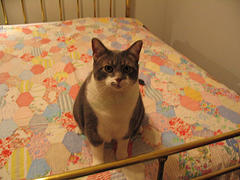

In [ ]:
real_image_path = '/content/drive/MyDrive/code/CASIA2/Au/Au_ani_10103.jpg'
Image.open(real_image_path)

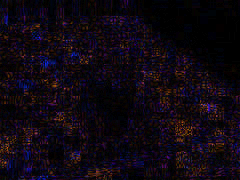

In [ ]:
convert_to_ela_image(real_image_path, 90)

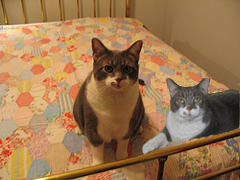

In [ ]:
fake_image_path = '/content/drive/MyDrive/code/CASIA2/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
Image.open(fake_image_path)

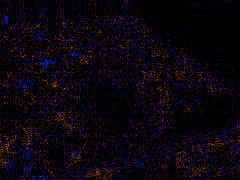

In [ ]:
convert_to_ela_image(fake_image_path, 90)

In [ ]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [ ]:
import random
path = '/content/drive/MyDrive/code/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
path = '/content/drive/MyDrive/code/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
# X = X.reshape(-1,1,1,1) # This line is incorrect and should be removed
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


#**Feature Learning**

In [ ]:
from transformers import ElectraTokenizer, ElectraModel, XLNetTokenizer, XLNetModel
import torch
import numpy as np

# Load pretrained models
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
electra_model = ElectraModel.from_pretrained('google/electra-base-discriminator')

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')

def get_electra_features(text):
    tokens = electra_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = electra_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # shape: (768,)

def get_xlnet_features(text):
    tokens = xlnet_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = xlnet_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # shape: (768,)

# Combine Electra + XLNet (Fusion)
def get_fused_text_features(text):
    f_electra = get_electra_features(text)
    f_xlnet = get_xlnet_features(text)
    return np.concatenate([f_electra, f_xlnet])  # shape: (1536,)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

# Load EfficientNetB0 base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
gap_layer = GlobalAveragePooling2D()(base_model.output)
image_model = Model(inputs=base_model.input, outputs=gap_layer)

def get_image_features(image_array):  # Input: shape (128, 128, 3)
    img = preprocess_input(np.expand_dims(image_array, axis=0))
    f_img = image_model.predict(img)
    return f_img.squeeze()  # shape: (1280,)


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def get_fused_features(image_array, text):
    f_img = get_image_features(image_array)            # Shape: (1280,)
    f_text = get_fused_text_features(text)             # Shape: (1536,)
    fused_vector = np.concatenate([f_img, f_text])     # Final shape: (2816,)
    return fused_vector


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

def build_model():
    inputs = Input(shape=(128,128,3))
    base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=inputs)
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="efficientnetB0")
    return model

model = build_model()
model.summary()


Model: "efficientnetB0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 4,335,998 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
epochs = 10
batch_size = 32

In [ ]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 20,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.6578 - loss: 0.6410 - val_accuracy: 0.4886 - val_loss: 0.6959
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.7314 - loss: 0.6048 - val_accuracy: 0.4886 - val_loss: 0.7036
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.7437 - loss: 0.5939 - val_accuracy: 0.4886 - val_loss: 0.7153
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7467 - loss: 0.5791 - val_accuracy: 0.4886 - val_loss: 0.7287
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.7502 - loss: 0.5659 - val_accuracy: 0.4886 - val_loss: 0.7406
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.7718 - loss: 0.5451 - val_accuracy: 0.4886 - val_loss: 0.7528
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7581 - loss: 0.5375 - val_accuracy: 0.4886 - val_loss: 0.7553
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.7690 - loss: 0.5247 - val_accu

In [ ]:
model.save('model_casia_run1.h5')

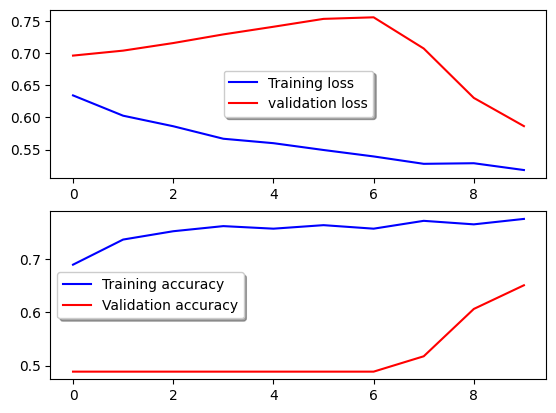

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step


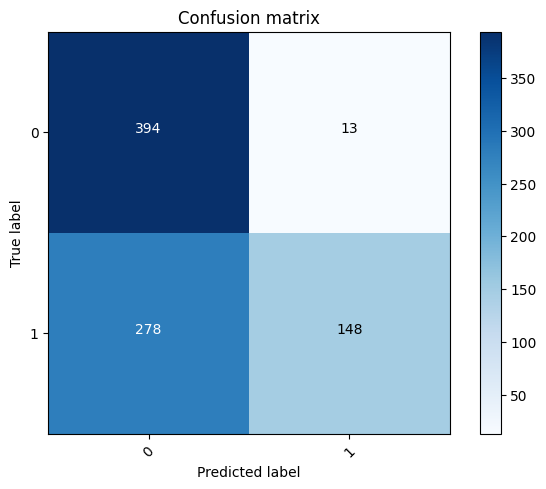

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

#**Ensemble Soft Voting**

In [ ]:
def explainable_soft_voting(predictions_list, attr_stats):
    """
    Combines soft voting and attribute explainability
    predictions_list: list of [P_real, P_fake] from models
    attr_stats: dict { 'attribute_name': (n_real, n_fake) }
    """
    label, avg_probs = soft_voting_ensemble(predictions_list)

    attr_explanations = {}
    for attr, (n_A, n_B) in attr_stats.items():
        p_r, p_f = conditional_probability(n_A, n_B)
        attr_explanations[attr] = (p_r, p_f)

    return label, avg_probs, attr_explanations


In [ ]:
class_names = ['fake', 'real']

In [ ]:
real_image_path = '/content/drive/MyDrive/code/CASIA2/Au/Au_ani_00002.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 0)[1]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
real_image = os.listdir('/content/drive/MyDrive/code/CASIA2/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/drive/MyDrive/code/CASIA2/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 0)[1]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
fake_image_path = '/content/drive/MyDrive/code/CASIA2/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
fake_image = os.listdir('/content/drive/MyDrive/code/CASIA2/Tp')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/drive/MyDrive/code/CASIA2/Tp', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

In [ ]:
pip install tensorflow keras lime opencv-python pillow scikit-image matplotlib


In [ ]:
pip install tensorflow opencv-python matplotlib


In [ ]:
pip install torch torchvision lime scikit-image matplotlib pillow opencv-python

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageChops, ImageEnhance
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Load image and preprocess
img_path = "/content/drive/MyDrive/code/CASIA2/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg"  # Replace with your input image
image_pil = Image.open(img_path).convert("RGB").resize((224, 224))
image_np = np.array(image_pil)

# Transform for PyTorch model
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Load pretrained model (replace with EfficientNetB0 if desired)
model = models.efficientnet_b0(pretrained=True)
model.eval()

# Prediction function for LIME
def batch_predict(images):
    batch = torch.stack([transform(Image.fromarray(img)).to(torch.float32) for img in images])
    with torch.no_grad():
        logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_np,
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=SegmentationAlgorithm("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
)

label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)

# Create ELA image
def convert_to_ela_image(image, quality=90):
    image.save("temp.jpg", "JPEG", quality=quality)
    ela_image = ImageChops.difference(image, Image.open("temp.jpg"))
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

ela_img = convert_to_ela_image(image_pil)
ela_np = np.array(ela_img.resize((224, 224)))

# Heatmap from LIME weights
heatmap_vals = np.zeros(mask.shape)
for i, weight in explanation.local_exp[label]:
    heatmap_vals[mask == i] = weight

# ------- Plot -------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# (a) Text output
axes[0, 0].axis("off")
textstr = (
    f"True Label: Fake\n"
    f"Predicted Label: Authentic\n"
    # Corrected line: removed explanation.available_labels()
    f"LIME Label:Fake {label}\n"
    f"LIME Probability: {batch_predict([image_np])[0][label]:.6f}\n"
    f"{{'Real(Authentic)': 1386, 'Fake': 1122}}"
)
axes[0, 0].text(0, 1, textstr, fontsize=12, verticalalignment='top', family='monospace')

# (b) Probabilistic heatmap
im1 = axes[0, 1].imshow(heatmap_vals, cmap='bwr')
axes[0, 1].set_title("Probabilistic HeatMap\nEfficientNetB0")
fig.colorbar(im1, ax=axes[0, 1])
axes[0, 1].axis("off")

# (c) Original image
axes[0, 2].imshow(image_np)
axes[0, 2].set_title("Original Image")
axes[0, 2].axis("off")

# (d) ELA image
axes[1, 0].imshow(ela_np)
axes[1, 0].set_title("ELA Image")
axes[1, 0].axis("off")

# (e) LIME mask image
axes[1, 1].imshow(mark_boundaries(temp / 255.0, mask))
axes[1, 1].set_title("MASHAP Image")
axes[1, 1].axis("off")

# (f) Superpixels on ELA
ela_for_lime = np.array(ela_img.resize((224, 224)))
axes[1, 2].imshow(mark_boundaries(ela_for_lime / 255.0, mask))
axes[1, 2].set_title("Superpixels area for ELA image")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
pip install transformers datasets scikit-learn pandas numpy


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from datasets import Dataset

# Load the Weibo dataset (ensure it's already preprocessed or translated if needed)
df = pd.read_csv("/content/drive/MyDrive/code/Weibo.csv")  # Update path

In [ ]:
pip install pillow numpy pandas opencv-python googletrans==4.0.0-rc1 nltk transformers


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import re
from nltk.corpus import stopwords
from googletrans import Translator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------ TEXT PROCESSING (TRANSLATE + CLEAN + TOKENIZE) ------------

stop_words = set(stopwords.words('english'))
translator = Translator()

def clean_text(text):
    # Translate Chinese to English (skip if already translated)
    try:
        text = translator.translate(text, src='zh-cn', dest='en').text
    except:
        pass  # handle slowdowns

    # Lowercase
    text = text.lower()
    # Remove punctuation, digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

def preprocess_text_series(text_series):
    return text_series.apply(clean_text)

# ------------ TEXT VECTORIZATION ------------

def vectorize_text(text_series, max_len=100):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_series)
    sequences = tokenizer.texts_to_sequences(text_series)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded, tokenizer

# ------------ EXAMPLE USAGE ------------

# Example: Process Weibo text CSV (translated or original)
df = pd.read_csv("/content/drive/MyDrive/Weibo.csv")  # must have 'text', 'label' columns

df['clean_text'] = preprocess_text_series(df['text'])
text_vectors, tokenizer = vectorize_text(df['clean_text'])

print("Text shape:", text_vectors.shape)



In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Layer
from tensorflow.keras.models import Model

# Wrap AutoModel in a Keras Layer
class TextEmbeddingLayer(Layer):
    def __init__(self, model_name="google/electra-small-discriminator", **kwargs):
        super(TextEmbeddingLayer, self).__init__(**kwargs)
        self.auto_model = TFAutoModel.from_pretrained(model_name)
        # self.auto_model.trainable = False # Can set to False here if needed

    def call(self, inputs):
        input_ids, attention_mask = inputs
        embeddings = self.auto_model(input_ids, attention_mask=attention_mask)[0]
        pooled_output = tf.reduce_mean(embeddings, axis=1)
        return pooled_output

# -------- IMAGE MODEL (EfficientNetB0) --------
def build_image_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base_model.trainable = False  # fine-tune later if needed

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    return base_model.input, x

# -------- TEXT MODEL (AutoModel as a Layer) --------
def build_text_model(max_len):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    text_embeddings = TextEmbeddingLayer()([input_ids, attention_mask])

    x = Dense(256, activation='relu')(text_embeddings)
    x = Dropout(0.3)(x)

    return [input_ids, attention_mask], x


# -------- MULTIMODAL FUSION --------
def build_multimodal_model(max_len):
    # Image branch
    img_input, img_features = build_image_model()

    # Text branch
    [text_input_ids, text_attention], text_features = build_text_model(max_len)

    # Fuse both
    merged = Concatenate()([img_features, text_features])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # for binary classification

    model = Model(inputs=[img_input, text_input_ids, text_attention], outputs=output)
    return model

In [ ]:
pip install lime scikit-learn matplotlib numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from lime.lime_text import LimeTextExplainer

# Sample training data in Spanish
texts = [
    "huracan destruye la ciudad",
    "inundaciones causan daños severos",
    "el presidente da un discurso importante",
    "la independencia de un país es celebrada",
    "noticia falsa sobre el huracan sandy",
    "mira esta imagen tremenda del huracan",
]
labels = [1, 1, 0, 0, 1, 1]  # 1 = Fake, 0 = Authentic

# Define and train the model pipeline
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(texts)
logistic_model = LogisticRegression() # Renamed variable to avoid conflict
logistic_model.fit(X, labels)
pipeline = sklearn.pipeline.make_pipeline(vectorizer, logistic_model)

# Text to explain (your example text)
test_text = "Every time a hurricane sweeps off the US coast, sharks swim up the street."

# Set class names
class_names_text = ['Authentic', 'Fake'] # Renamed variable to avoid conflict
explainer = LimeTextExplainer(class_names=class_names_text)

# Explain the instance
exp = explainer.explain_instance(test_text, pipeline.predict_proba, num_features=10)

# Show prediction
probs = pipeline.predict_proba([test_text])[0]
print(f"Prediction probabilities:\nAuthentic: {probs[0]:.2f}\nFake: {probs[1]:.2f}")

# Show explanation inline
exp.show_in_notebook(text=test_text)

# Save figure like in your image
fig = exp.as_pyplot_figure()
fig.suptitle("LIME Explanation for Fake News Detection", fontsize=14)
fig.tight_layout()
fig.savefig("lime_fake_news_spanish.png")